In [47]:
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [54]:
# crack the dataset open
df = pd.read_excel('data/Audatex_Claims.Updated(2021).xlsx')

df.columns, len(df.columns)

(Index(['CREATIONDATE', 'ASSESSMENTNUMBER', 'ORIGINATOR',
        'CLAIMREFERENCENUMBER', 'CLAIMNUMBER', 'WORKPROVIDER', 'BROKER',
        'CALCULATIONDATE', 'MANUFACTURERNAME', 'MODELNAME', 'SUBMODELTEXT',
        'YEARREG', 'MONTHREG', 'BODYCOLOUR', 'ODOMETER', 'NUMBERMODELOPTIONS',
        'ASSESSOR', 'REPAIRERNAME', 'USERSTATUS', 'AUTHSTATUS',
        'WARRANTYSTATUS', 'DAMAGESEVERITY', 'DRIVEABLE', 'INSUREDAMOUNT',
        'TOTALCOSTOFCLAIM', 'PARTSAMT', 'SUNDRYPARTSAMT', 'TOTALLABOURAMT',
        'TOTALPAINTLABOURCOST', 'TOTALPAINTMATERIALCOST', 'TOTALADDITIONALAMT',
        'BLOCKCODE', 'WASTECOLLECTIONTOTALAMT', 'LABOURHOURS', 'PAINTHOURS',
        'LABOURRATE', 'PAINTRATE', 'NUMBEROFPARTS', 'TYRECONDITION',
        'PREACCIDENTCONDITION', 'STEERINGCONDITION', 'BRAKES', 'IMPACTSOURCE',
        'IMPACTDES', 'JDENUMBER', 'SITEID', 'Insurer', 'Month', 'Year'],
       dtype='object'),
 49)

In [55]:
# basic exploration
print(df.info())  # check data types and missing values
print(df['TOTALCOSTOFCLAIM'].describe())  # summary stats for target
print(df.isnull().sum())  # check missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89450 entries, 0 to 89449
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CREATIONDATE             89450 non-null  datetime64[ns]
 1   ASSESSMENTNUMBER         89450 non-null  object        
 2   ORIGINATOR               89450 non-null  object        
 3   CLAIMREFERENCENUMBER     89449 non-null  object        
 4   CLAIMNUMBER              89449 non-null  object        
 5   WORKPROVIDER             89450 non-null  object        
 6   BROKER                   89141 non-null  object        
 7   CALCULATIONDATE          89450 non-null  datetime64[ns]
 8   MANUFACTURERNAME         89450 non-null  object        
 9   MODELNAME                89450 non-null  object        
 10  SUBMODELTEXT             89159 non-null  object        
 11  YEARREG                  89144 non-null  float64       
 12  MONTHREG                 89144 n

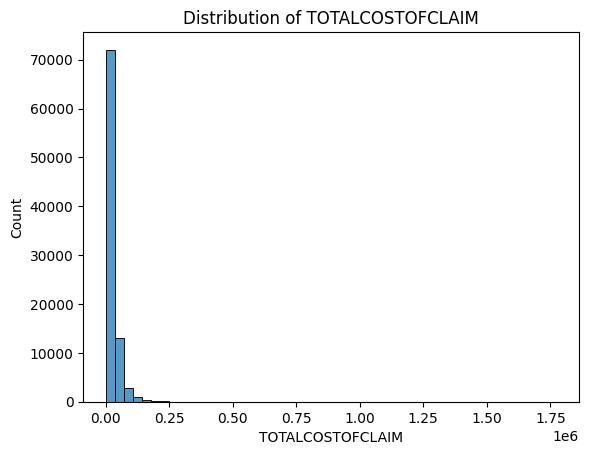

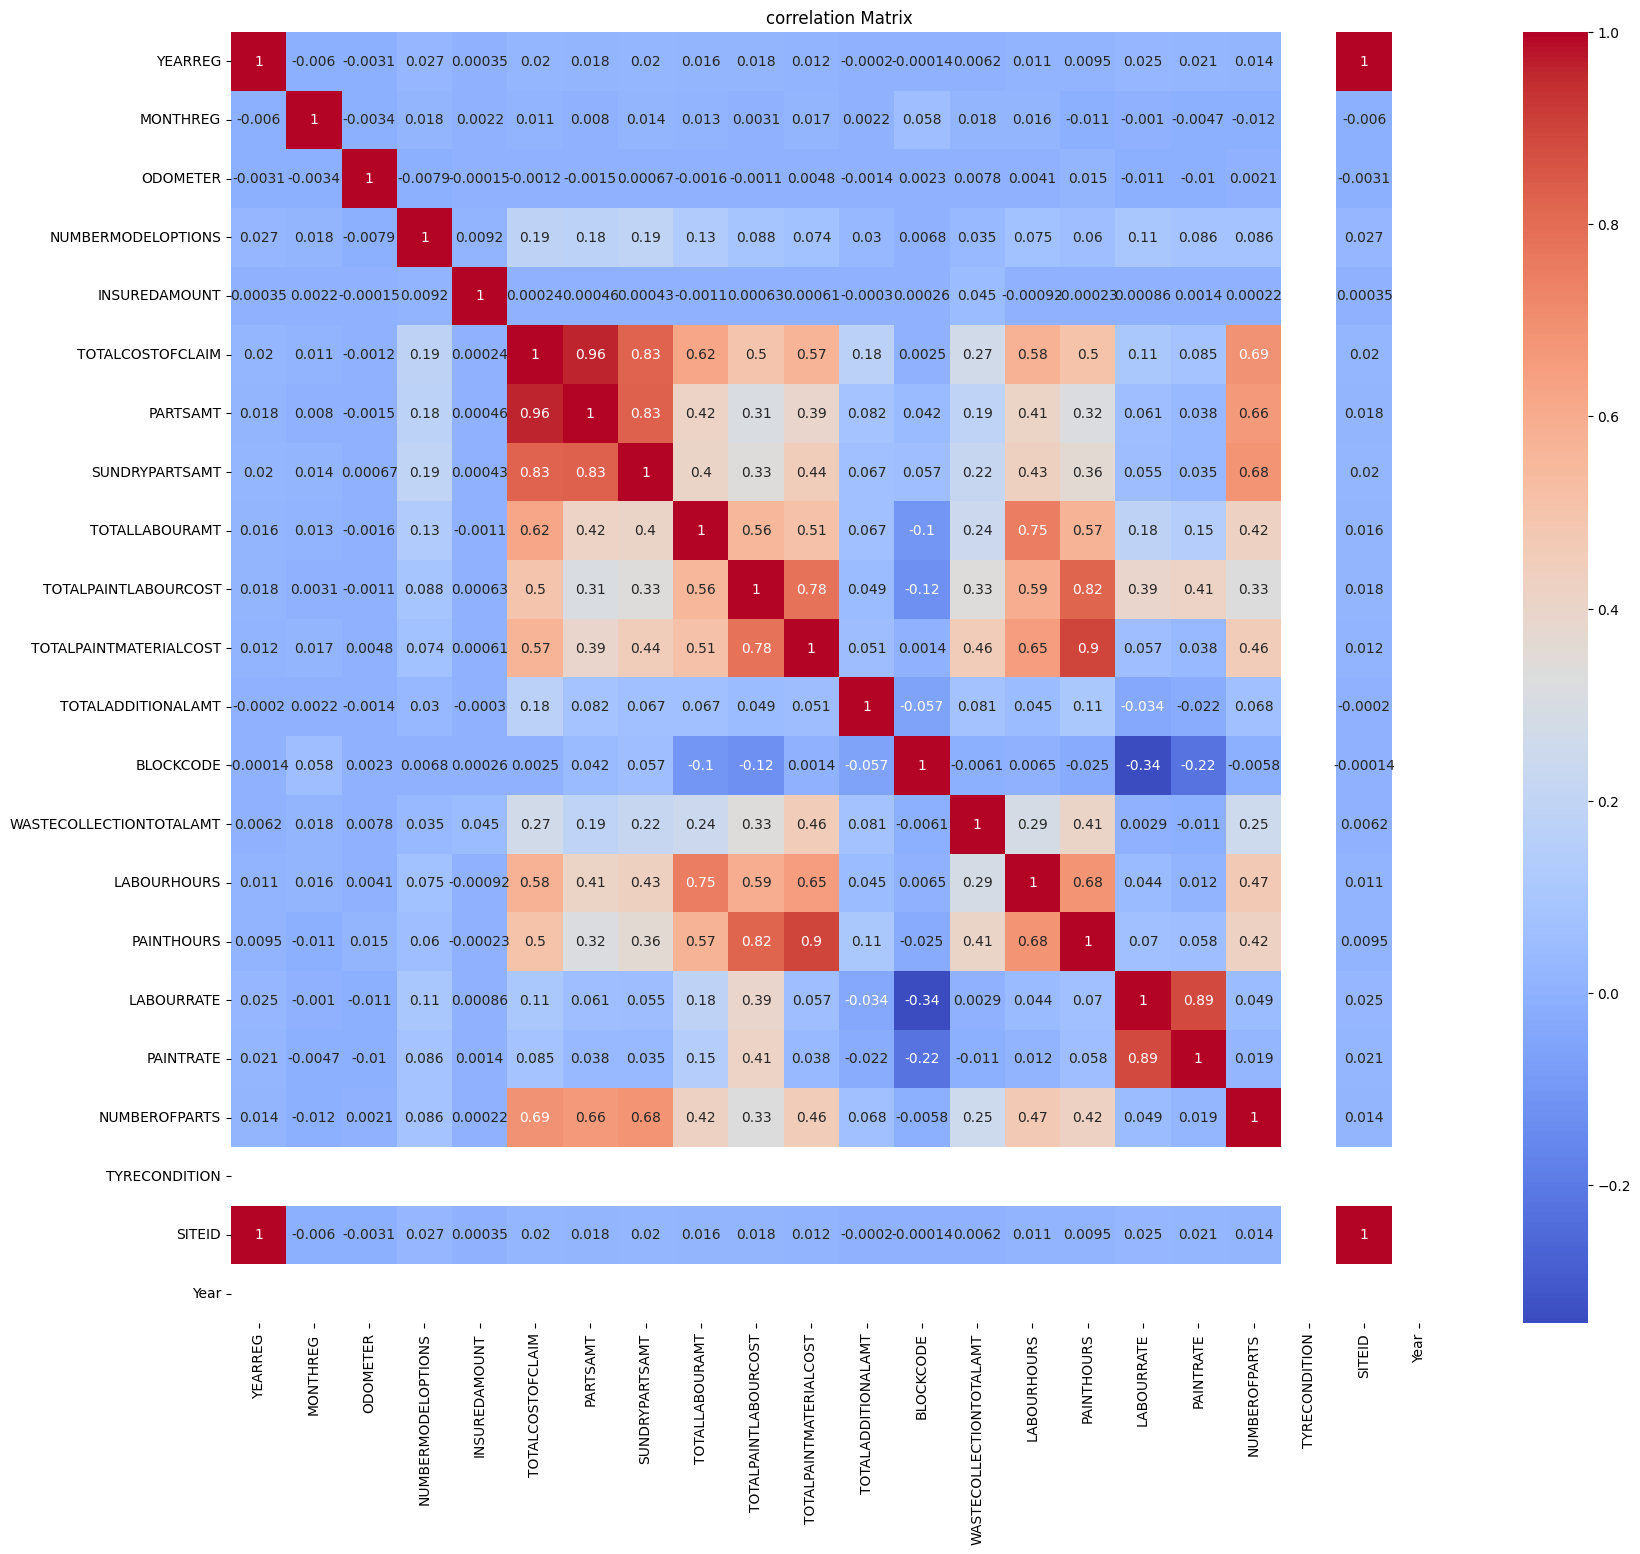

In [56]:
# visualize target distribution
sns.histplot(df['TOTALCOSTOFCLAIM'], bins=50)
pl.title('Distribution of TOTALCOSTOFCLAIM')
pl.show()

# correlation with numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
pl.title('correlation Matrix')
pl.subplots_adjust(right=2.5, top=2.8)
pl.show()

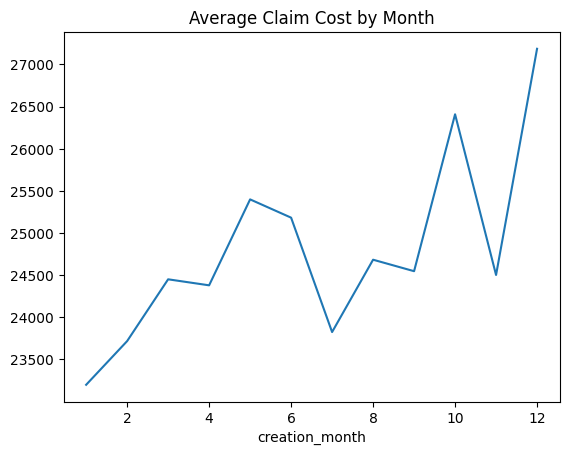

In [73]:
df['CREATIONDATE'] = pd.to_datetime(df['CREATIONDATE'])
df['CALCULATIONDATE'] = pd.to_datetime(df['CALCULATIONDATE'])
df['creation_year'] = df['CREATIONDATE'].dt.year
df['creation_month'] = df['CREATIONDATE'].dt.month
df['creation_day'] = df['CREATIONDATE'].dt.day
df['time_diff_days'] = (df['CALCULATIONDATE'] - df['CREATIONDATE']).dt.days

monthly_cost = df.groupby('creation_month')['TOTALCOSTOFCLAIM'].mean()
sns.lineplot(x=monthly_cost.index, y=monthly_cost.values)
pl.title('Average Claim Cost by Month')
pl.show()

                                                         mean  count
DAMAGESEVERITY                                                      
Major Structural Repairs                         37478.654516   7029
Other                                            34456.164032   1131
Major Structural Repairs Factory (Oem Approved)  33199.659664  19073
Advanced Structural Repairs                      22663.978343  30634
Non-Structural Repairs                           18628.946938  31583


/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/3212355711.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DAMAGESEVERITY', y='TOTALCOSTOFCLAIM', data=df, estimator=np.mean, ci=None)


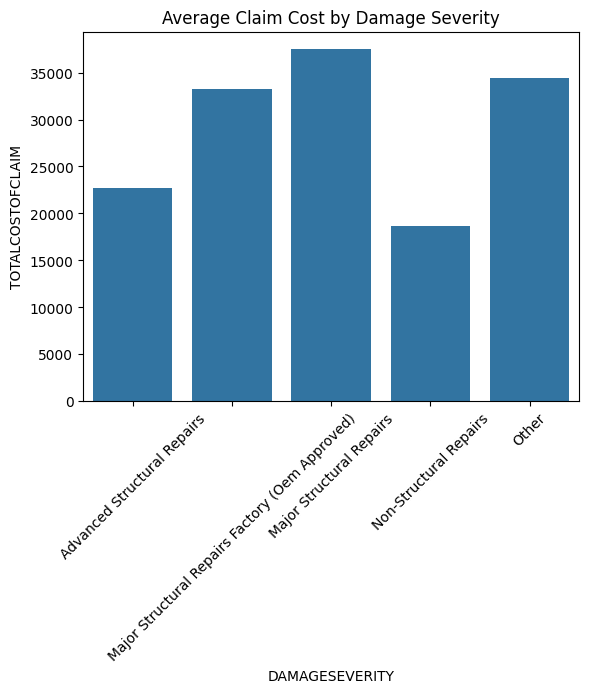

In [75]:
severity_cost = df.groupby('DAMAGESEVERITY')['TOTALCOSTOFCLAIM'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print(severity_cost)

sns.barplot(x='DAMAGESEVERITY', y='TOTALCOSTOFCLAIM', data=df, estimator=np.mean, ci=None)
pl.title('Average Claim Cost by Damage Severity')
pl.xticks(rotation=45)
pl.show()

REPAIRERNAME
Alberante ARC                                 266765.590
TRANS LETABA PANEL BEATERS                    259265.350
Star Body Works (NAM)                         243755.615
ESANI PANELBAETERS                            208869.850
RENEW IT SANDTON                              207914.890
BMW GEORGE                                    187494.160
M&L Panelbeaters (MBR)                        176587.330
BODYTECH 2000                                 173694.410
Sovereign ARC - Bloemfontein (MBR) (S/R) ^    169320.670
HJ BOSCH AND SONS PANELBEATERS HERCULES       162332.850
Name: TOTALCOSTOFCLAIM, dtype: float64


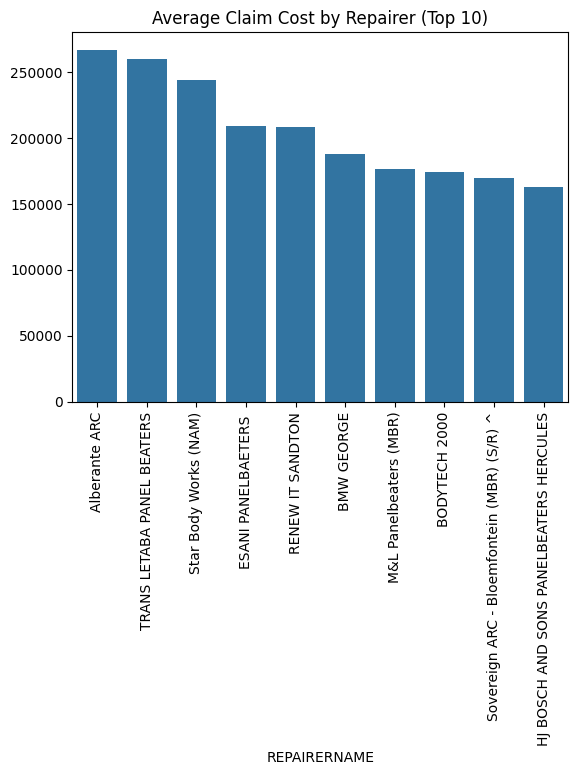

In [76]:
repairer_cost = df.groupby('REPAIRERNAME')['TOTALCOSTOFCLAIM'].mean().sort_values(ascending=False)
print(repairer_cost.head(10))

sns.barplot(x=repairer_cost.head(10).index, y=repairer_cost.head(10).values)
pl.title('Average Claim Cost by Repairer (Top 10)')
pl.xticks(rotation=90)
pl.show()

/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/61320834.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  odometer_cost = df.groupby('ODOMETER_BIN')['TOTALCOSTOFCLAIM'].mean()


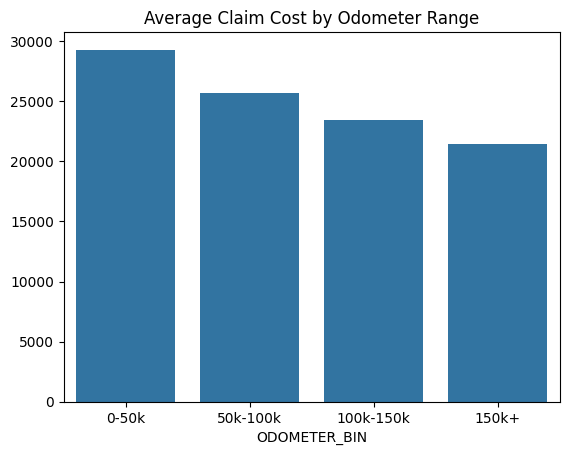

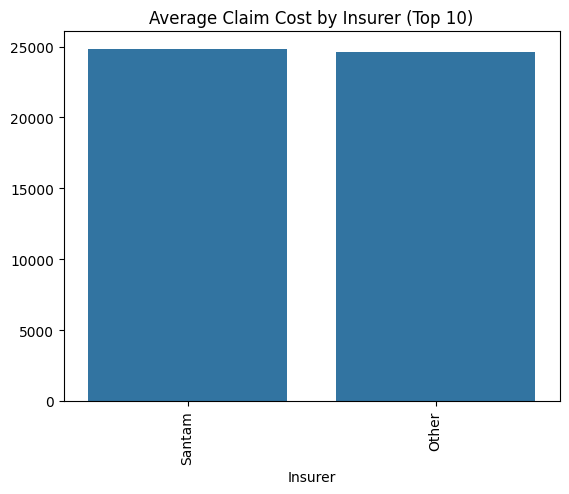

In [ ]:
df['ODOMETER_BIN'] = pd.cut(df['ODOMETER'], bins=[0, 50000, 100000, 150000, float('inf')], labels=['0-50k', '50k-100k', '100k-150k', '150k+'])
odometer_cost = df.groupby('ODOMETER_BIN')['TOTALCOSTOFCLAIM'].mean()

sns.barplot(x=odometer_cost.index, y=odometer_cost.values)
pl.title('Average Claim Cost by Odometer Range')
pl.show()



/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


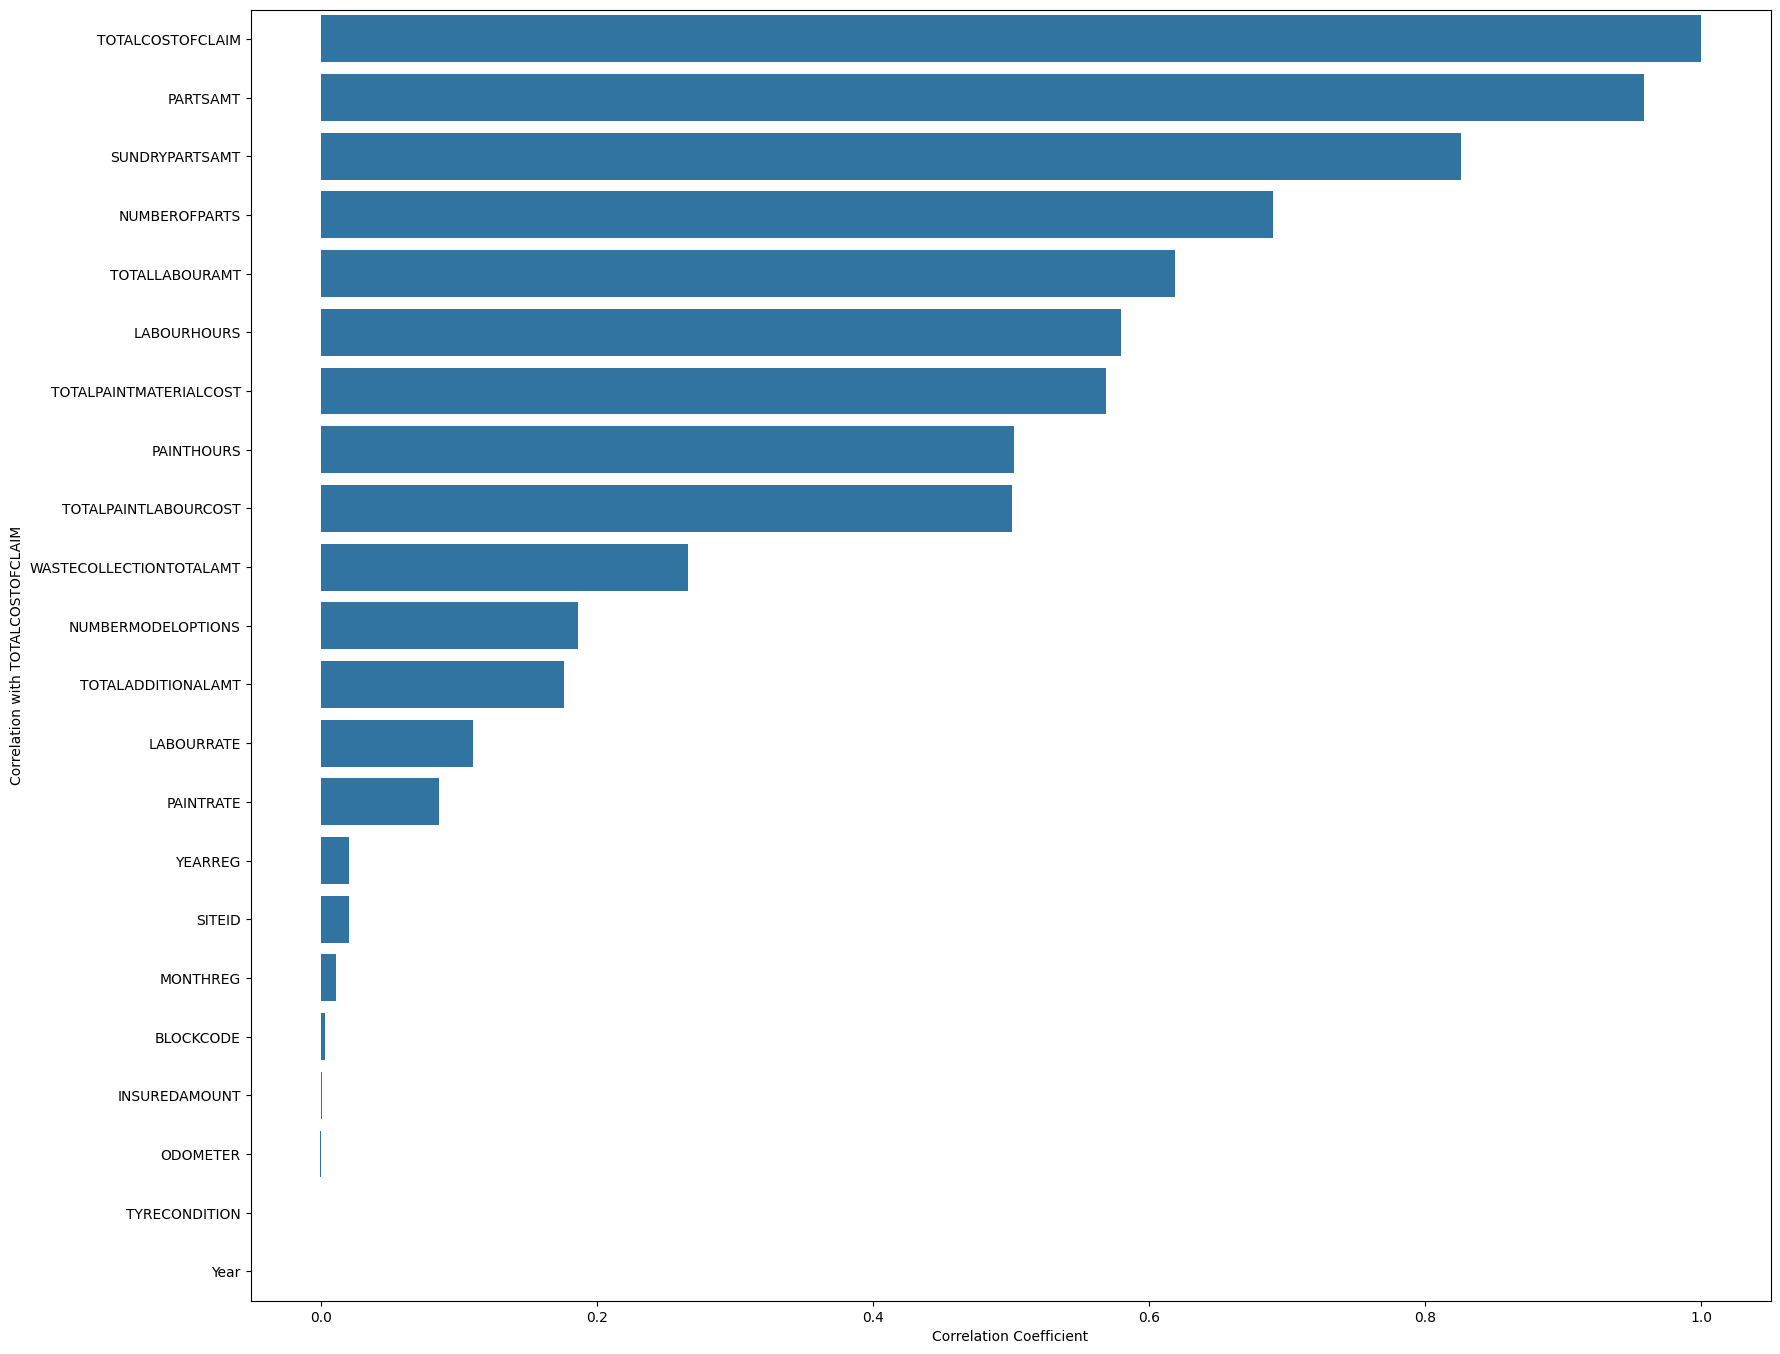

In [59]:
correlations = df[numerical_cols].corrwith(df['TOTALCOSTOFCLAIM']).sort_values(ascending=False)
sns.barplot(x=correlations.values, y=correlations.index)
pl.subplots_adjust(right=2.5, top=2.8)
pl.ylabel('Correlation with TOTALCOSTOFCLAIM')
pl.xlabel('Correlation Coefficient')
pl.show()

In [60]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlations = df[numerical_cols].corrwith(df['TOTALCOSTOFCLAIM']).sort_values(ascending=False)
threshold = 0.3
influential_cols = correlations[abs(correlations) > threshold].index.tolist()
if 'TOTALCOSTOFCLAIM' not in influential_cols:
    influential_cols.append('TOTALCOSTOFCLAIM')
df_filtered = df[influential_cols]

/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [62]:
# handle missing values
numerical_cols_filtered = df_filtered.select_dtypes(include=['float64', 'int64']).columns.drop('TOTALCOSTOFCLAIM')
df_filtered[numerical_cols_filtered] = df_filtered[numerical_cols_filtered].fillna(df_filtered[numerical_cols_filtered].median())
categorical_cols_filtered = df_filtered.select_dtypes(include=['object']).columns
for col in categorical_cols_filtered:
    df_filtered[col] = df_filtered[col].fillna('Unknown')


/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/3447228584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[numerical_cols_filtered] = df_filtered[numerical_cols_filtered].fillna(df_filtered[numerical_cols_filtered].median())


In [ ]:
# outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numerical_cols_filtered:
    original_len = len(df_filtered)
    df_filtered = remove_outliers(df_filtered, col)
    print(f"removed {original_len - len(df_filtered)} outliers from {col}")
print(f"new dataset shape: {df_filtered.shape}")

Removed 6688 outliers from PARTSAMT
Removed 2770 outliers from SUNDRYPARTSAMT
Removed 3707 outliers from NUMBEROFPARTS
Removed 5453 outliers from TOTALLABOURAMT
Removed 2294 outliers from LABOURHOURS
Removed 1805 outliers from TOTALPAINTMATERIALCOST
Removed 1363 outliers from PAINTHOURS
Removed 1272 outliers from TOTALPAINTLABOURCOST
New dataset shape: (64098, 9)


Number of numerical columns: 9


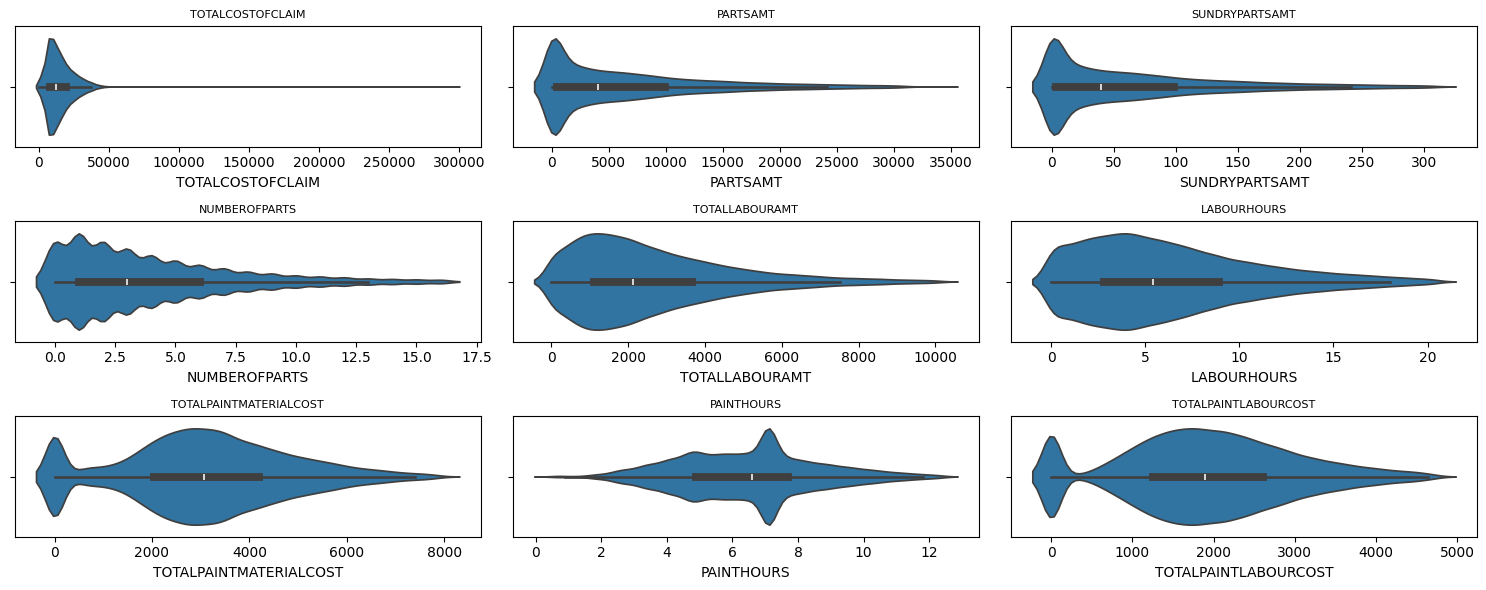

In [67]:
# filter numerical columns for outlier visualization
numerical_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns
print(f"Number of numerical columns: {len(numerical_cols)}")

# create subplots for numerical columns only
n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # Calculate rows needed

fig, ax = pl.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 2))
ax = ax.flatten()  # Flatten the 2D array of axes for easier indexing

# plot violin plots for numerical columns
for i, col in enumerate(numerical_cols):
    sns.violinplot(x=df_filtered[col], orient='h', ax=ax[i])
    ax[i].set_title(col, fontsize=8)

# remove empty subplots if any
for i in range(len(numerical_cols), len(ax)):
    fig.delaxes(ax[i])

pl.tight_layout()
pl.show()

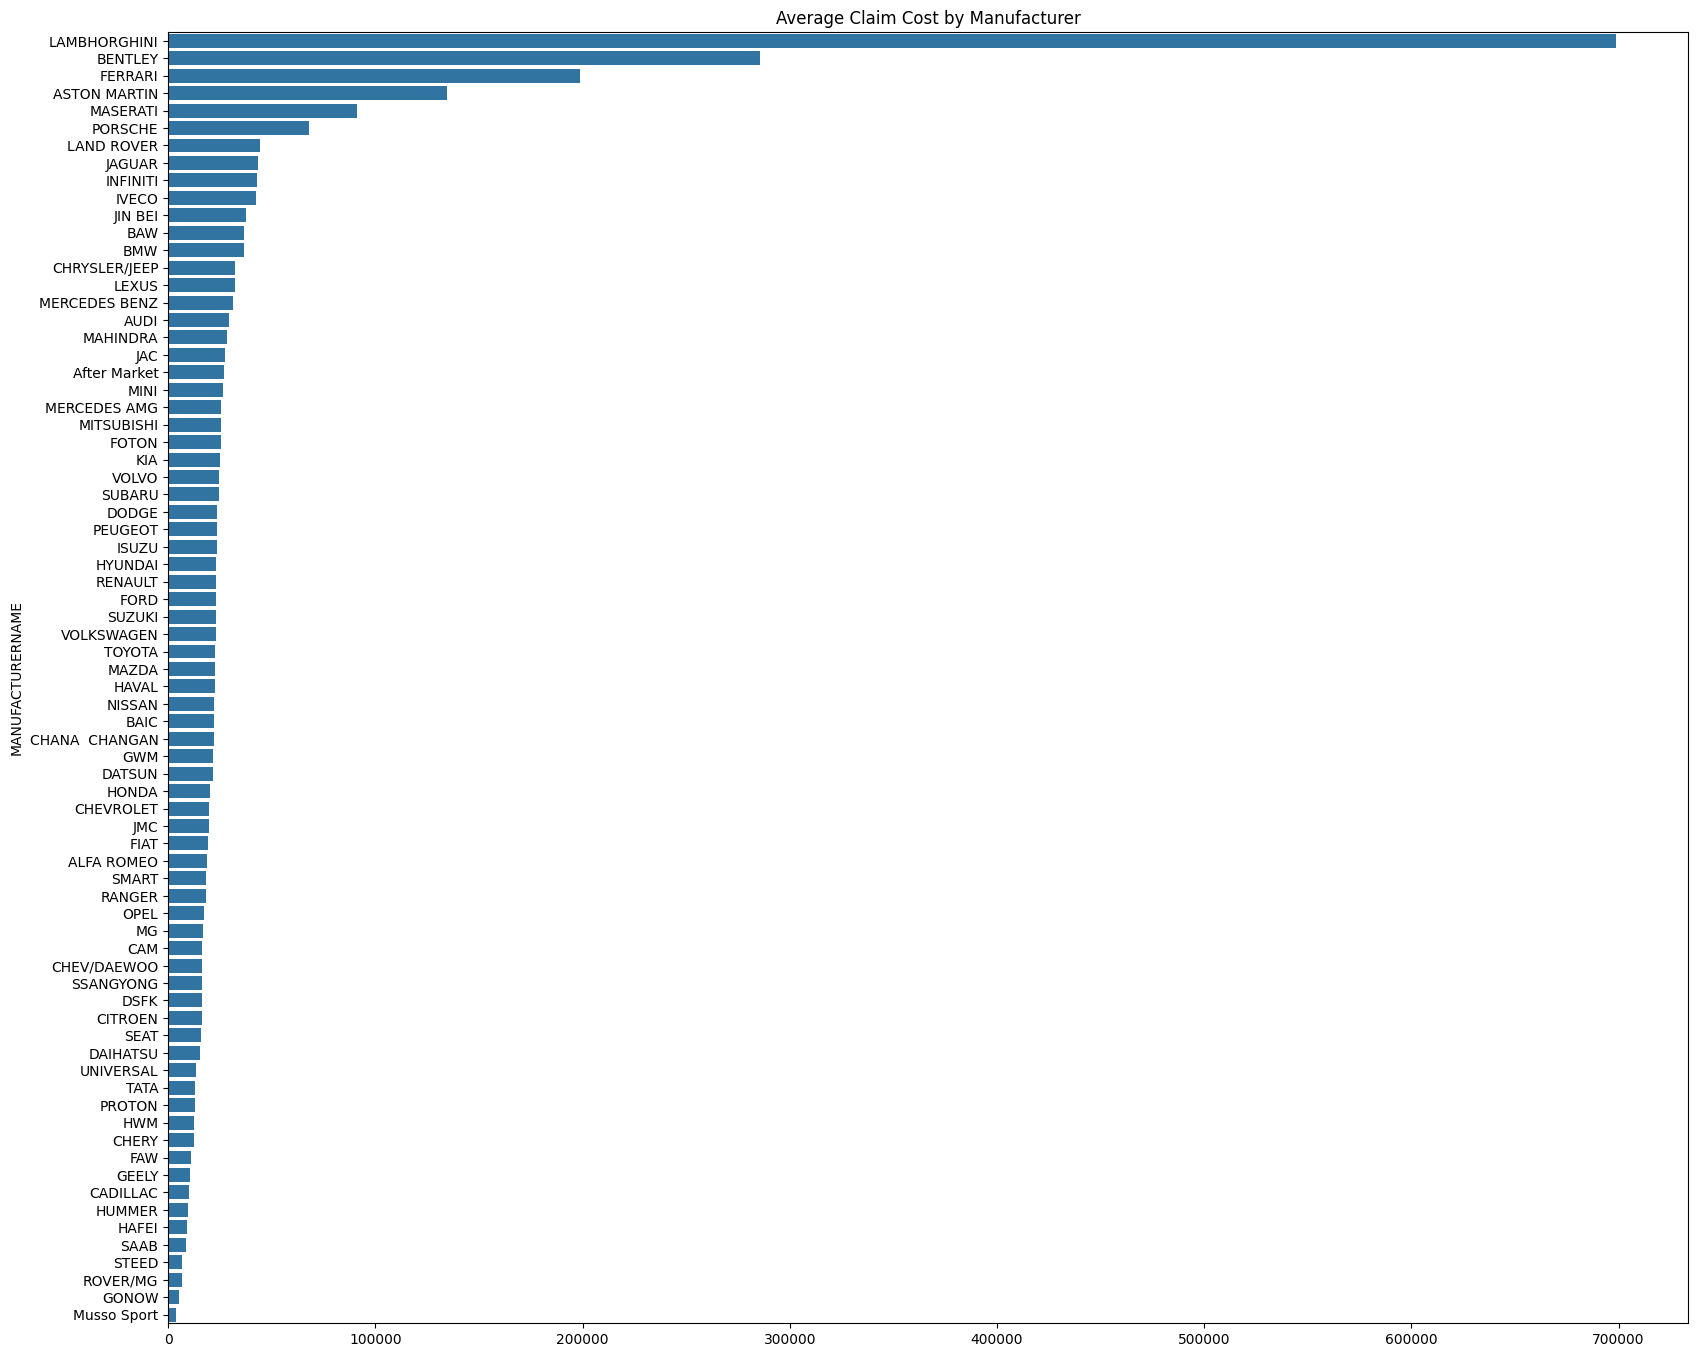

In [68]:
manufacturer_cost = df.groupby('MANUFACTURERNAME')['TOTALCOSTOFCLAIM'].mean().sort_values(ascending=False)
sns.barplot(x=manufacturer_cost.values, y=manufacturer_cost.index)
pl.title('Average Claim Cost by Manufacturer')
pl.subplots_adjust(right=2.5, top=2.8)
pl.show()

In [69]:

# Encode categorical columns
for col in categorical_cols_filtered:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col].astype(str))

# Scale numerical features
scaler = StandardScaler()
df_filtered[numerical_cols_filtered] = scaler.fit_transform(df_filtered[numerical_cols_filtered])

# Prepare data for modeling
X = df_filtered.drop('TOTALCOSTOFCLAIM', axis=1)
y = df_filtered['TOTALCOSTOFCLAIM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# Train and evaluate model
rf = RandomForestRegressor(random_state=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 2492.1874868973873
R²: 0.9284268273039556


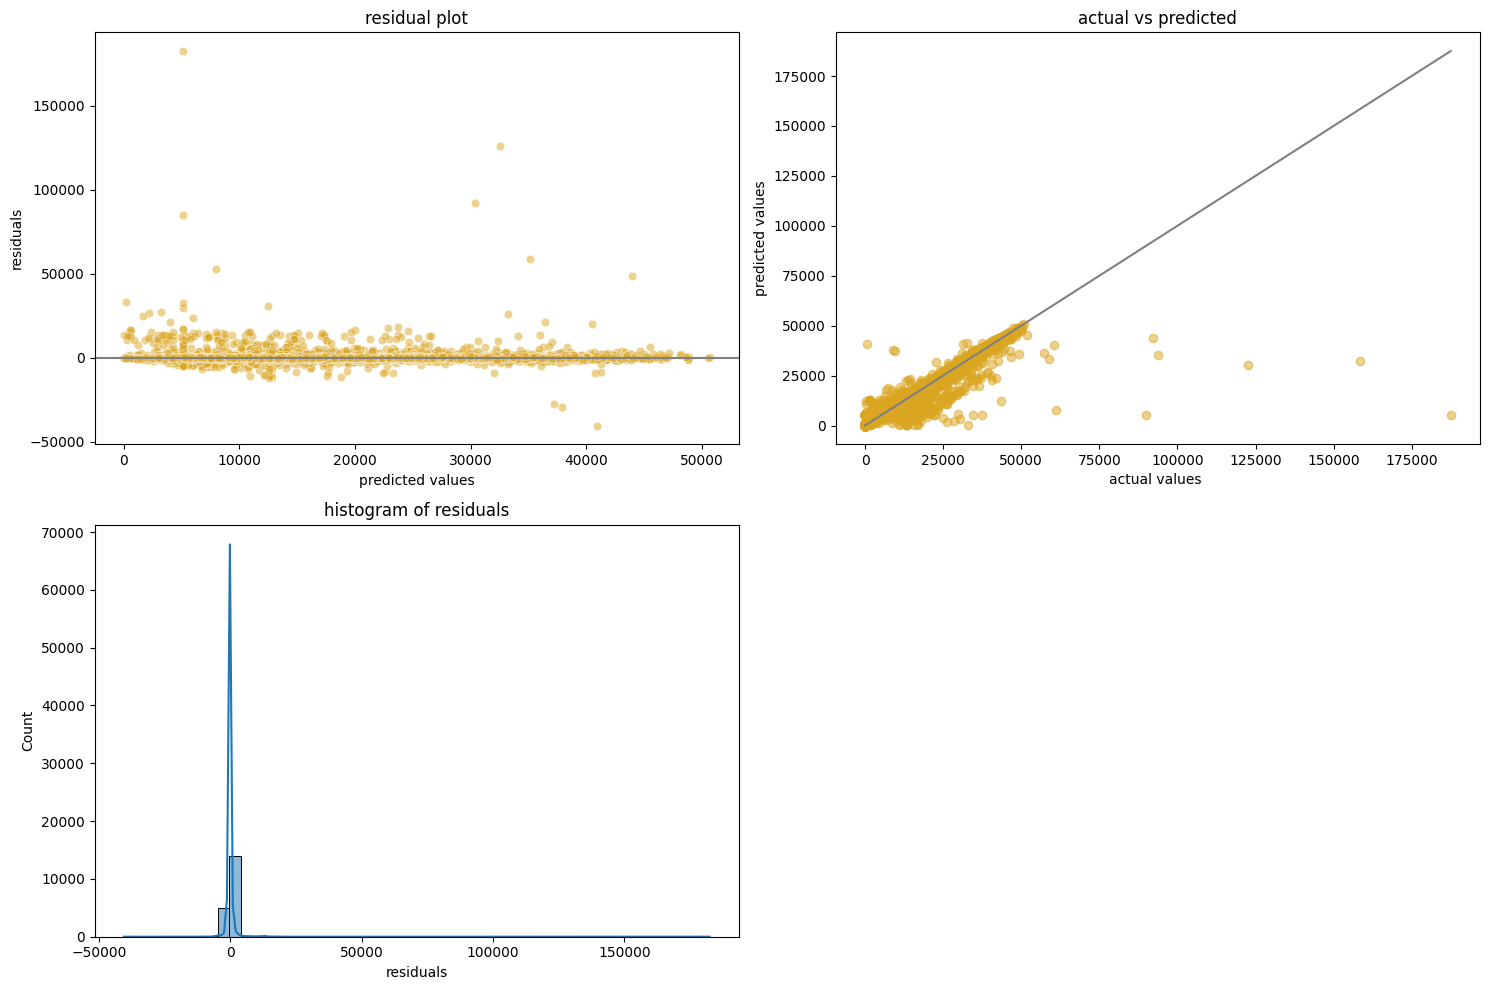

In [71]:
residuals = y_test - y_pred

fig, axes = pl.subplots(2, 2, figsize=(15, 10))

# Residual Plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='goldenrod', ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='grey', linestyle='-')
axes[0, 0].set_xlabel('predicted values')
axes[0, 0].set_ylabel('residuals')
axes[0, 0].set_title('residual plot')

# Actual vs Predicted
axes[0, 1].scatter(y_test, y_pred, alpha=0.5, color='goldenrod')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                color='grey', linestyle='-')
axes[0, 1].set_xlabel('actual values ')
axes[0, 1].set_ylabel('predicted values')
axes[0, 1].set_title('actual vs predicted')

# Histogram of Residuals
sns.histplot(residuals, bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('residuals')
axes[1, 0].set_title('histogram of residuals')

# # Boxplot of Residuals
# sns.boxplot(x=residuals, ax=axes[1, 1])
# axes[1, 1].set_xlabel('residuals')
# axes[1, 1].set_title('boxplot of residuals')

fig.delaxes(axes[1, 1])

pl.tight_layout()
pl.show()